In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from wrangle import wrangle_zillow
from evaluate import baseline_mean_errors, better_than_baseline, regression_errors, plot_residuals, mets, eval_score, more_table
from explore import plot_categorical_and_continuous_vars, plot_variable_pairs
from sklearn.feature_selection import SelectKBest, f_regression, RFE

## Acquisition and Preparation

In [2]:
# grabbing data, cleaning, and splitting
df = wrangle_zillow()
df = df.drop(columns='parcelid')
train_and_validate, test = train_test_split(df, random_state=117)
train, validate = train_test_split(train_and_validate)

x_train = train.drop(columns={'beds', 'value', 'year_built', 'county'})
y_train = train['value']
x_validate = validate.drop(columns={'beds', 'value', 'year_built', 'county'})
y_validate = validate['value']
x_test = test.drop(columns={'beds', 'value', 'year_built', 'county'})
y_test = test['value']

In [3]:
# a quick look to see what we're seeing
train.sample(5)

,beds,baths,square_feet,value,year_built,county
1330001,2,1.0,952,45921,1928,6037.0
1394831,2,1.0,870,289948,1942,6037.0
786180,4,2.0,1726,442448,1955,6111.0
224253,4,3.0,2435,683452,1963,6059.0
1161127,5,6.5,6521,1840000,1991,6059.0


## Exploration

In [4]:
# visualizing correlation of features
value_corr = train.corr()
value_corr

,beds,baths,square_feet,value,year_built,county
beds,1.000000,0.640202,0.610058,0.258916,0.378617,0.136696
baths,0.640202,1.000000,0.838828,0.504058,0.512008,0.099294
square_feet,0.610058,0.838828,1.000000,0.608380,0.439698,0.094913
value,0.258916,0.504058,0.608380,1.000000,0.189289,0.017245
year_built,0.378617,0.512008,0.439698,0.189289,1.000000,0.301407
county,0.136696,0.099294,0.094913,0.017245,0.301407,1.000000


## Select a dataset with a continuous target variable.

In [6]:
df = wrangle_zillow()
df.head()

,beds,baths,square_feet,value,year_built,county,parcelid
4,4,2.0,3633,296425,2005,6037.0,11324547
6,3,4.0,1620,847770,2011,6037.0,11544747
7,3,2.0,2077,646760,1926,6037.0,11585547
18,3,1.0,1244,169471,1950,6037.0,12716947
19,3,2.0,1300,233266,1950,6037.0,12757147


## Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [7]:
# the data is all in numeric form
df.dtypes

beds             int64
baths          float64
square_feet      int64
value            int64
year_built       int64
county         float64
parcelid         int64
dtype: object

In [8]:
# making sure there's no nulls
df.isnull().sum()

beds           0
baths          0
square_feet    0
value          0
year_built     0
county         0
parcelid       0
dtype: int64

In [9]:
# splitting the data
train_and_validate, test = train_test_split(df, random_state=117)
train, validate = train_test_split(train_and_validate)

x_train = train.drop(columns={'value'})
y_train = train['value']
x_validate = validate.drop(columns={'value'})
y_validate = validate['value']
x_test = test.drop(columns={'value'})
y_test = test['value']

### Determining the best scaler

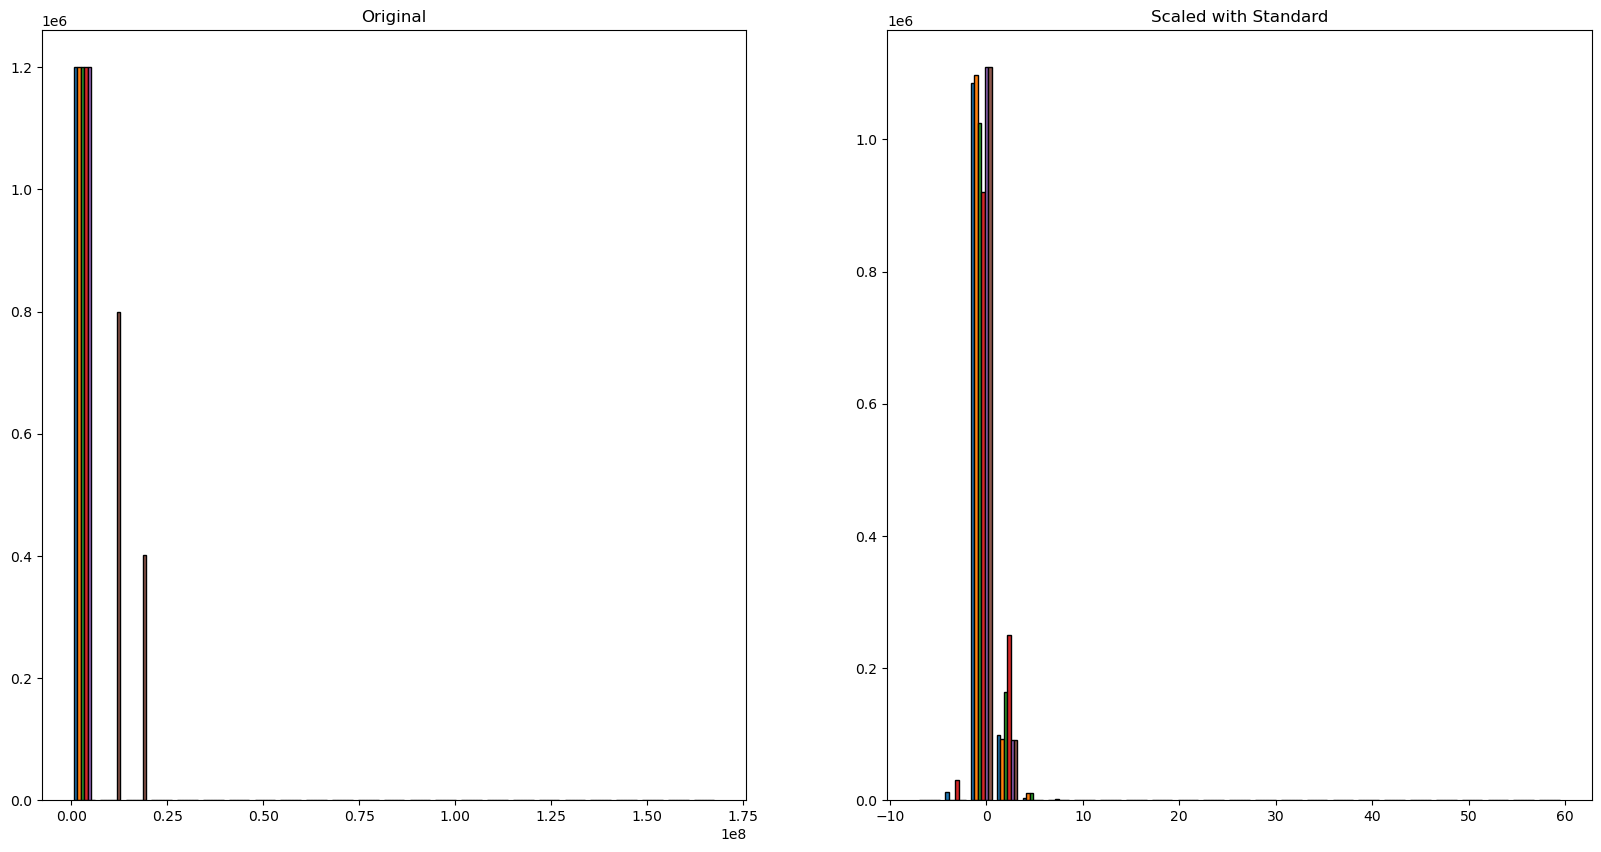

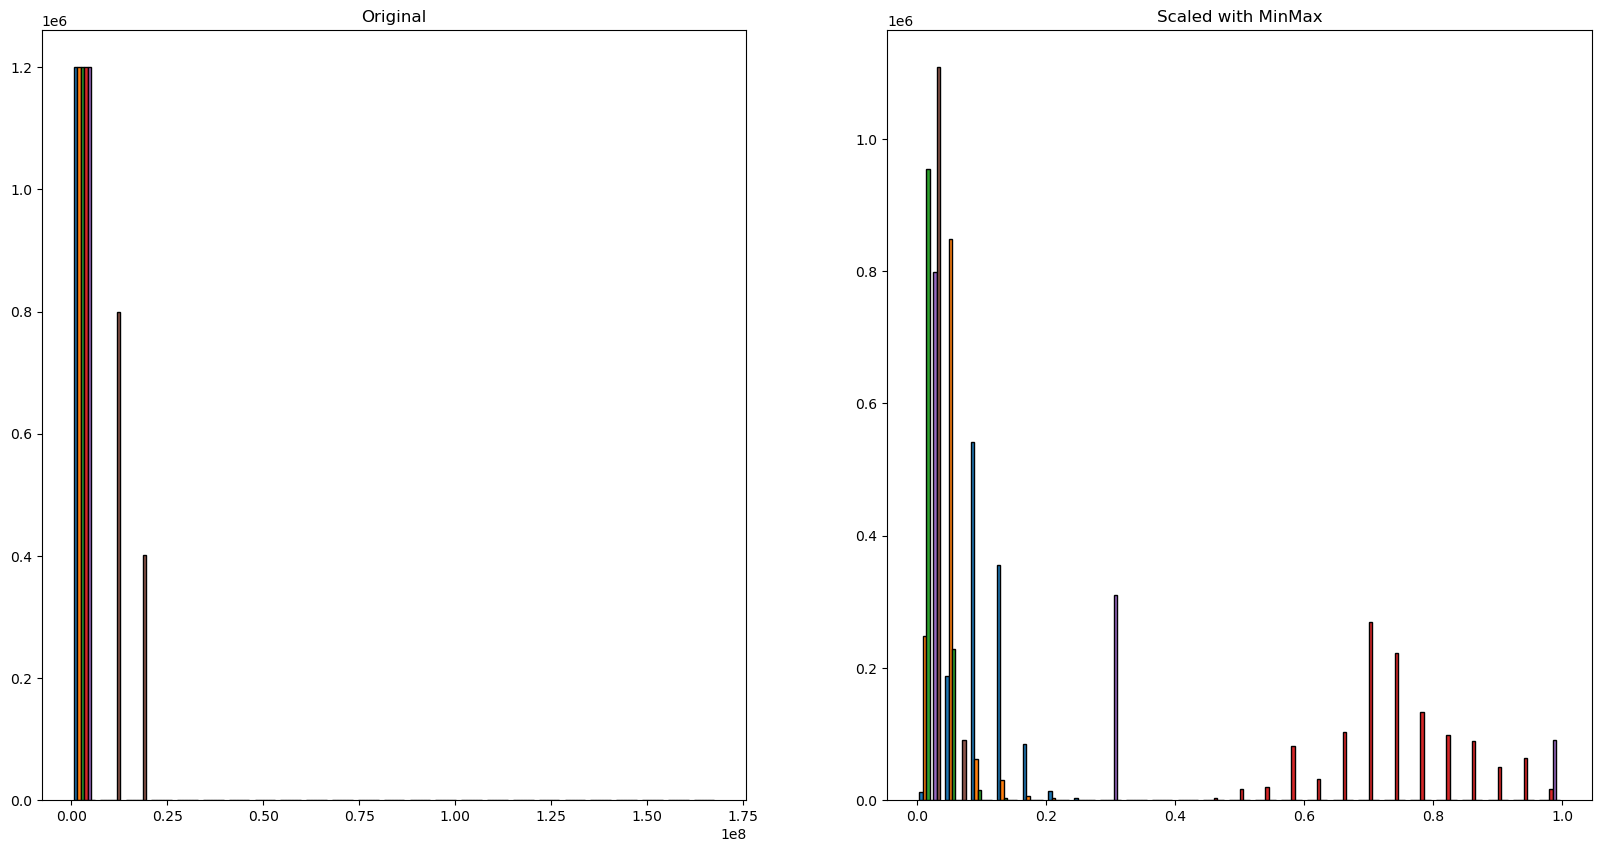

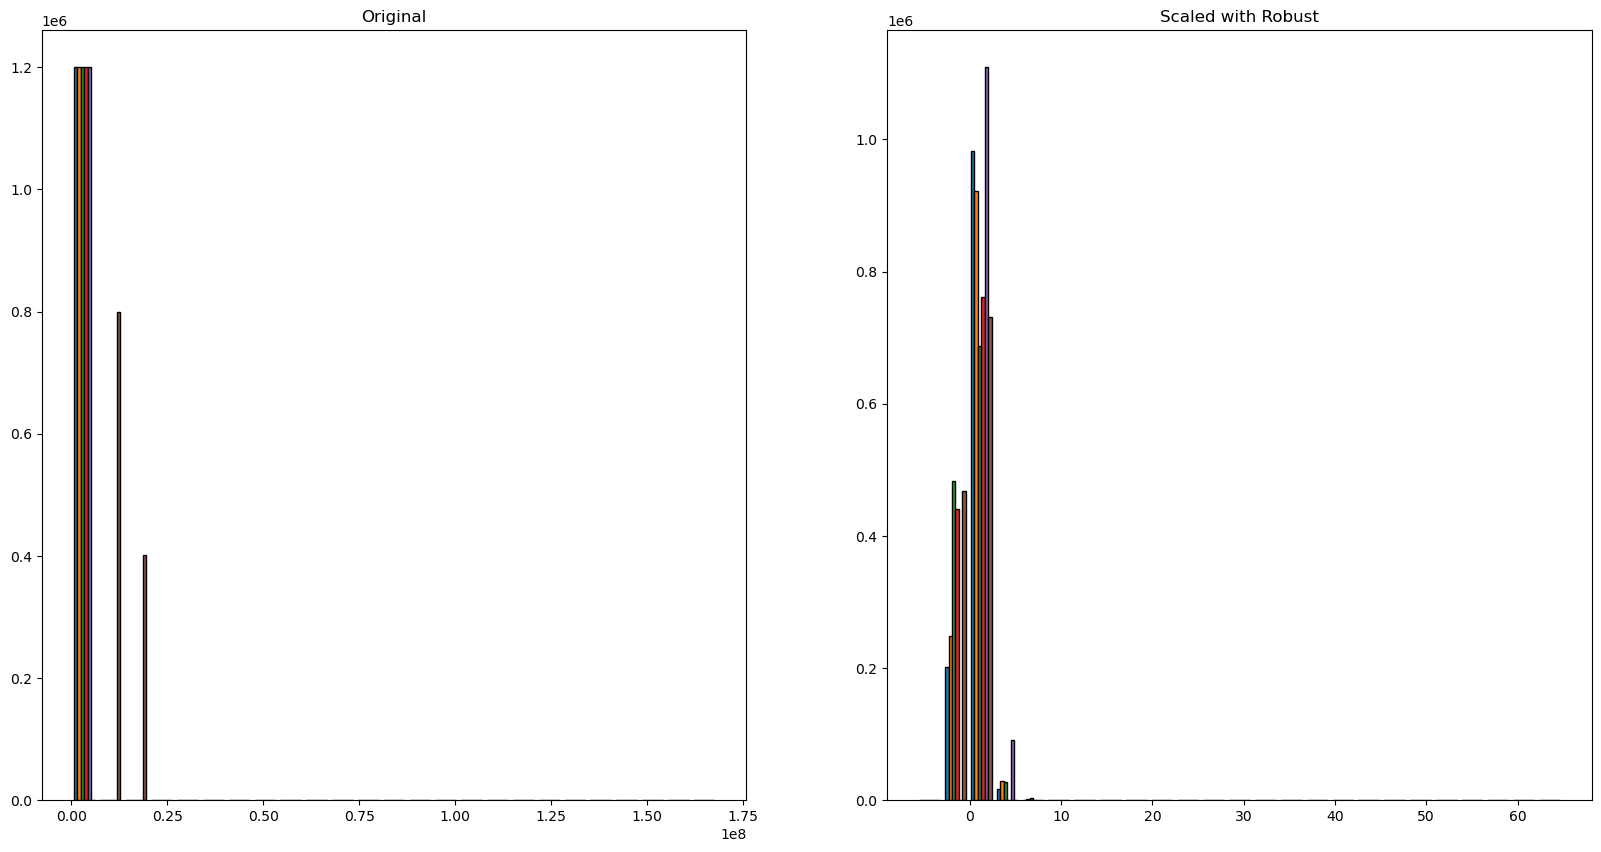

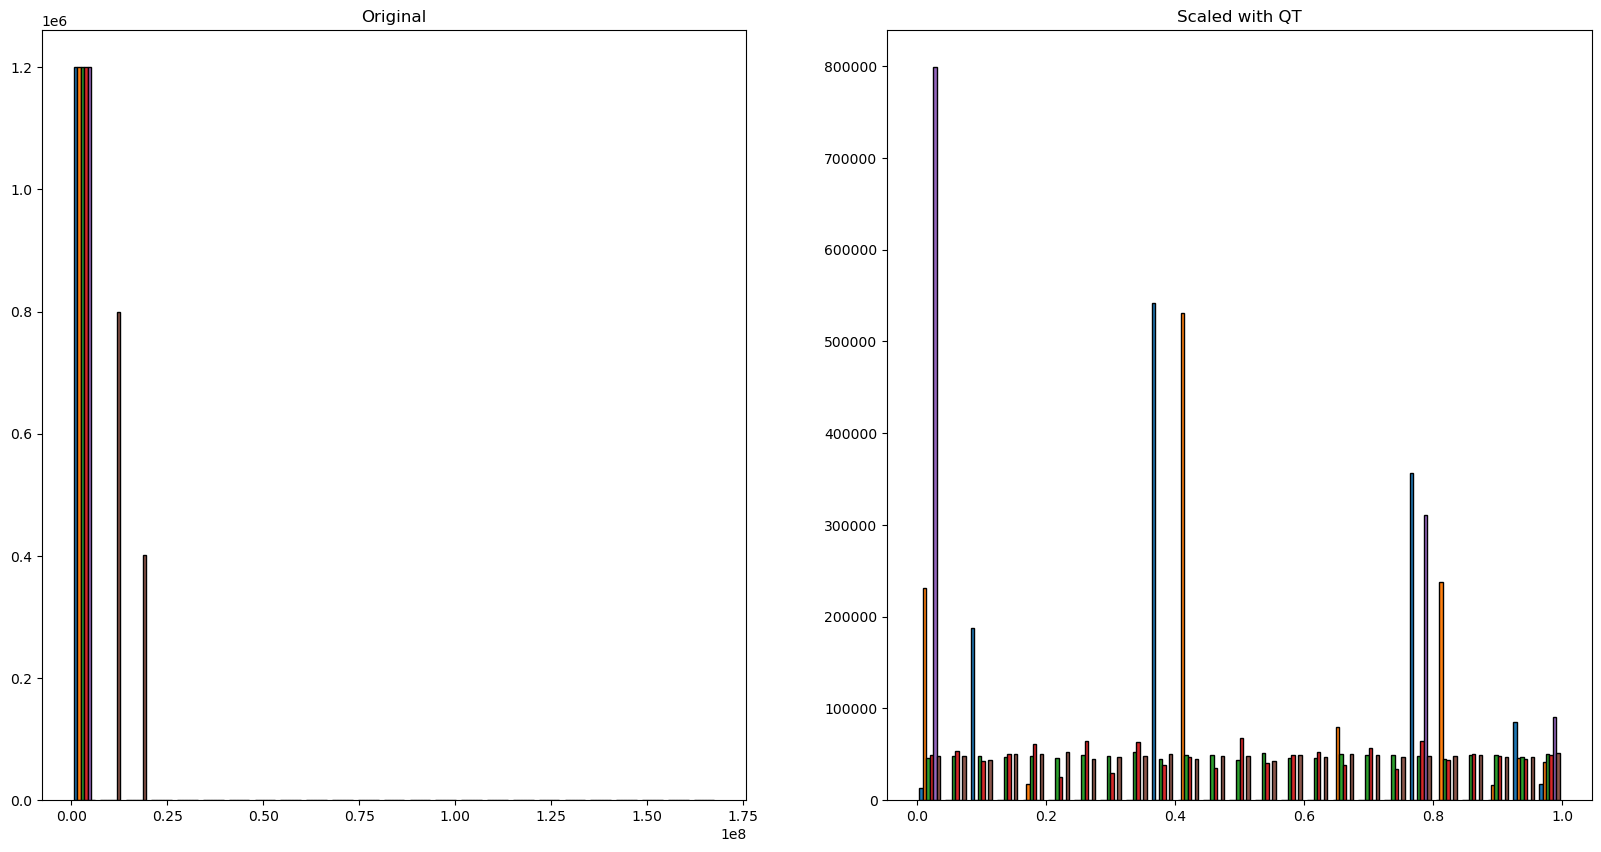

In [10]:
# Determining best scaler to use with data
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with Standard')
plt.show()


scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with MinMax')
plt.show()


scaler = sklearn.preprocessing.RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with Robust')
plt.show()


scaler = sklearn.preprocessing.QuantileTransformer()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with QT')
plt.show()

In [11]:
# Scaling the data to Robust scaler since it performed the best
scaler = sklearn.preprocessing.RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

In [12]:
lr1 = LinearRegression()
rfe = RFE(lr1, n_features_to_select=1)
rfe.fit(x_train_scaled, y_train)
rfe_train_feature = rfe.transform(x_train_scaled)
rfe_validate_feature = rfe.transform(x_validate_scaled)

In [13]:
lr1 = LinearRegression()
rfe = RFE(lr1, n_features_to_select=1)
rfe.fit(x_train_scaled, y_train)
rfe_train_feature = rfe.transform(x_train_scaled)
rfe_validate_feature = rfe.transform(x_validate_scaled)
rfe.get_feature_names_out()

array(['x2'], dtype=object)

sns.histplot(y_train)
plt.xlim([0, 2000000])
plt.show()

## Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

### Establishing baseline and making a dataframe to visually reference easier

In [14]:
def mets(y, y_pred):
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    return rmse, r2

In [15]:
baseline =y_train.mean()
baseline_array = np.repeat(baseline, len(train))
rmse, r2 = mets(y_train, baseline_array)
mets_df = pd.DataFrame(data=[{'Model':'Baseline', 'RMSE':rmse, 'R2':r2}])

train_target_pred_mean = y_train.mean()
validate_target_pred_mean = y_validate.mean()


train_target_pred_median = y_train.median()
validate_target_pred_median = y_validate.median()

In [16]:
mets_df

,Model,RMSE,R2
0,Baseline,675932.040919,0.0


### Now to try out different models and see what's optimal

In [17]:
score_df = pd.DataFrame(data=[{'Model':'Baseline', 'RMSE':rmse, 'R2':r2}])
lr1.fit(rfe_train_feature, y_train)
pred_train_lr1 = lr1.predict(rfe_train_feature)
pred_validate_lr1 = lr1.predict(rfe_validate_feature)
pred_train_lr1


mets(y_train, pred_train_lr1)

(536877.200991428, 0.3691242180654011)

#### LinearRegression (OLS)

In [18]:
lr1.fit(rfe_train_feature, y_train)
pred_train_lr1 = lr1.predict(rfe_train_feature)
pred_validate_lr1 = lr1.predict(rfe_validate_feature)
pred_train_lr1

array([155356.61721635, 424739.44055012, 371718.0594495 , ...,
       591500.23594722, 240447.38204717, 494864.49297352])

In [19]:
mets(y_train, pred_train_lr1)

(536877.200991428, 0.3691242180654011)

In [20]:
val_rmse, val_r2 = mets(y_validate, pred_validate_lr1)
val_rmse, val_r2

(561893.0813703171, 0.36759024121182493)

In [21]:
mets_df.loc[1] = ['OLS_1', val_rmse, val_r2]
mets_df

,Model,RMSE,R2
0,Baseline,675932.040919,0.00000
1,OLS_1,561893.081370,0.36759


In [22]:
lr1.intercept_

358035.1223912809

In [23]:
lr1.coef_

array([406212.19391601])

In [24]:
lr2 = LinearRegression()
lr2.fit(x_train_scaled, y_train)
pred_lr2 = lr2.predict(x_train_scaled)
pred_val_lr2 = lr2.predict(x_validate_scaled)
pred_lr2

array([ 31433.26244543, 477445.42989356, 414018.9278769 , ...,
       459060.3773493 , 251325.80308405, 539123.32510283])

In [25]:
mets(y_train, pred_lr2)

(525062.0832251103, 0.3965861871867771)

In [26]:
rmse, r2 = mets(y_validate, pred_val_lr2)
rmse, r2

(549488.7764629223, 0.3952040892013299)

In [28]:
mets_df.loc[2] = ['OLS', rmse, r2]
mets_df

,Model,RMSE,R2
0,Baseline,675932.040919,0.000000
1,OLS_1,561893.081370,0.367590
2,OLS,549488.776463,0.395204


#### LassoLars

In [50]:
lars = LassoLars(alpha=3)
lars.fit(x_train_scaled, y_train)
pred_lars = lars.predict(x_train_scaled)
pred_lars_val = lars.predict(x_validate_scaled)

In [51]:
mets(y_train, pred_lars)

(525062.0833216403, 0.39658618696490777)

In [31]:
def eval_score(y_validate, pred_val):
    rmse, r2 = mets(y_validate, pred_val)
    return rmse, r2

def more_table(row, row_name, res1, res2):
    rmse, r2 = res1, res2
    mets_df.loc[row] = [row_name, rmse, r2]
    return mets_df

In [52]:
rmse, r2= eval_score(y_validate, pred_lars_val)
more_table(3, 'Lars', rmse, r2)

,Model,RMSE,R2
0,Baseline,6.759320e+05,0.000000e+00
1,OLS_1,5.618931e+05,3.675902e-01
2,OLS,5.494888e+05,3.952041e-01
3,Lars,5.494889e+05,3.952038e-01
4,Poly Reg,5.059000e+05,4.873505e-01
5,TweedieRegressor 1,5.724985e+05,3.434921e-01
6,TweedieRegressor 2,5.494888e+05,3.952041e-01
7,TweedieRegressor 2,2.168622e+09,-9.420171e+06


#### Polynomial Regression

In [34]:
pf = PolynomialFeatures(degree=2)
x_train_scaled_degree2 = pf.fit_transform(x_train_scaled)
x_validate_degree2 = pf.transform(x_validate_scaled)

In [35]:
pr = LinearRegression()
pr.fit(x_train_scaled_degree2, y_train)
pred_pr = pr.predict(x_train_scaled_degree2)
pred_val_pr = pr.predict(x_validate_degree2)

In [36]:
mets(y_train, pred_pr)

(494064.1748188837, 0.46573015771649195)

In [37]:
rmse, r2 = eval_score(y_validate, pred_val_pr)
more_table(4, 'Poly Reg deg 2', rmse, r2)

,Model,RMSE,R2
0,Baseline,675932.040919,0.000000
1,OLS_1,561893.081370,0.367590
2,OLS,549488.776463,0.395204
3,Lars,549488.827599,0.395204
4,Poly Reg,505899.980957,0.487351


In [53]:
pf = PolynomialFeatures(degree=3)
x_train_scaled_degree3 = pf.fit_transform(x_train_scaled)
x_validate_degree3 = pf.transform(x_validate_scaled)
pr = LinearRegression()
pr.fit(x_train_scaled_degree3, y_train)
pred_pr = pr.predict(x_train_scaled_degree3)
pred_val_pr = pr.predict(x_validate_degree3)

In [54]:
mets(y_train, pred_pr)

(484031.4162331801, 0.48720824466364754)

In [56]:
rmse, r2 = eval_score(y_validate, pred_val_pr)
more_table(5, 'Poly Reg deg3', rmse, r2)

,Model,RMSE,R2
0,Baseline,6.759320e+05,0.000000e+00
1,OLS_1,5.618931e+05,3.675902e-01
2,OLS,5.494888e+05,3.952041e-01
3,Lars,5.494889e+05,3.952038e-01
4,Poly Reg,5.059000e+05,4.873505e-01
5,Poly Reg deg3,5.095069e+05,4.800143e-01
6,TweedieRegressor 2,5.494888e+05,3.952041e-01
7,TweedieRegressor 2,2.168622e+09,-9.420171e+06


#### TweedieRegressor (GLM)

In [38]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train_scaled, y_train)
pred_glm = glm.predict(x_train_scaled)
pred_val_glm = glm.predict(x_validate_scaled)

In [39]:
mets(y_train, pred_glm)

(4203485.323721793, -37.67345775632661)

In [40]:
rmse, r2 = eval_score(y_validate, pred_val_glm)
more_table(6, 'TweedieRegressor 1', rmse, r2)

,Model,RMSE,R2
0,Baseline,675932.040919,0.000000
1,OLS_1,561893.081370,0.367590
2,OLS,549488.776463,0.395204
3,Lars,549488.827599,0.395204
4,Poly Reg,505899.980957,0.487351
5,TweedieRegressor 1,572498.522971,0.343492


In [41]:
glm2 = TweedieRegressor(power=0, alpha=0)
glm2.fit(x_train_scaled, y_train)
pred_glm2 = glm2.predict(x_train_scaled)
pred_val_glm2 = glm2.predict(x_validate_scaled)

In [42]:
mets(y_train, pred_glm2)

(525062.0832251103, 0.39658618718677696)

In [43]:
rmse, r2 = eval_score(y_validate, pred_val_glm2)
more_table(7, 'TweedieRegressor 2', rmse, r2)

,Model,RMSE,R2
0,Baseline,675932.040919,0.000000
1,OLS_1,561893.081370,0.367590
2,OLS,549488.776463,0.395204
3,Lars,549488.827599,0.395204
4,Poly Reg,505899.980957,0.487351
5,TweedieRegressor 1,572498.522971,0.343492
6,TweedieRegressor 2,549488.776590,0.395204


In [44]:
glm3 = TweedieRegressor(power=2, alpha=0)
glm3.fit(x_train_scaled, y_train)
pred_glm3 = glm3.predict(x_train_scaled)
pred_val_glm3 = glm3.predict(x_validate_scaled)

In [45]:
mets(y_train, pred_glm3)

(93123688143136.78, -1.898078930514965e+16)

In [46]:
rmse, r2 = eval_score(y_validate, pred_val_glm3)
more_table(8, 'TweedieRegressor 2', rmse, r2)

,Model,RMSE,R2
0,Baseline,6.759320e+05,0.000000e+00
1,OLS_1,5.618931e+05,3.675902e-01
2,OLS,5.494888e+05,3.952041e-01
3,Lars,5.494888e+05,3.952040e-01
4,Poly Reg,5.059000e+05,4.873505e-01
5,TweedieRegressor 1,5.724985e+05,3.434921e-01
6,TweedieRegressor 2,5.494888e+05,3.952041e-01
7,TweedieRegressor 2,2.168622e+09,-9.420171e+06


Baseline is off by about $675,932

Best model Poly Reg is off by about $505,900

Percent of variance (R$^2$) by Poly Reg is 48.73%